# K Fold Cross Validation (1)
- 대상 파일: `ICDAR17_Korean/ufo/train.json`
- train set과 validation set을 나누어보자.
- `sklearn`의 `StratifiedGroupKFold`를 사용한다.
    - group = image
    - class = bbox_size 별

## 1. train data EDA - 기본
- `OCR_EDA_train.ipynb` 참고

In [1]:
%matplotlib inline
import glob
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path
from PIL import Image
from collections import Counter
import numpy as np

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
def read_json(filename):
    with Path(filename).open(encoding='utf8') as handle:
        ann = json.load(handle)
    return ann

In [6]:
# gt file과 raw image file path를 이용해 데이터를 불러온다. 아래 경로는 예시.
data = read_json("../../input/data/ICDAR17_Korean/ufo/train.json")

In [7]:
def get_box_size(quads):
    """ 단어 영역의 사각형 좌표가 주어졌을 때 가로, 세로길이를 계산해주는 함수.
    TODO: 각 변의 길이를 단순히 max로 처리하기때문에 직사각형에 가까운 형태가 아니면 약간 왜곡이 있다.
    Args:
        quads: np.ndarray(n, 4, 2) n개 단어 bounding-box의 4개 점 좌표 (단위 pixel)
    Return:
        sizes: np.ndarray(n, 2) n개 box의 (height, width)쌍
    """
    dists = []
    for i, j in [(1, 2), (3, 0), (0, 1), (2, 3)]: # [right(height), left(height), upper(width), lower(width)] sides
        dists.append(np.linalg.norm(quads[:, i] - quads[:, j], ord=2, axis=1))

    dists = np.stack(dists, axis=-1).reshape(-1, 2, 2) # shape (n, 2, 2) widths, heights into separate dim
    return np.rint(dists.mean(axis=-1)).astype(int)

In [8]:
def rectify_poly(poly, direction, img_w, img_h):
    """일반 polygon형태인 라벨을 크롭하고 rectify해주는 함수.
    Args:
        poly: np.ndarray(2n+4, 2) (where n>0), 4, 6, 8
        image: np.ndarray opencv 포멧의 이미지
        direction: 글자의 읽는 방향과 진행 방향의 수평(Horizontal) 혹은 수직(Vertical) 여부
    Return:
        rectified: np.ndarray(2, ?) rectify된 단어 bbox의 사이즈.
    """
    
    n_pts = poly.shape[0]
    assert n_pts % 2 == 0
    if n_pts == 4:
        size = get_box_size(poly[None])
        h = size[:, 0] / img_h
        w = size[:, 1] / img_w
        return np.stack((h,w))

    def unroll(indices):
        return list(zip(indices[:-1], indices[1:]))

    # polygon하나를 인접한 사각형 여러개로 쪼갠다.
    indices = list(range(n_pts))
    if direction == 'Horizontal':
        upper_pts = unroll(indices[:n_pts // 2]) # (0, 1), (1, 2), ... (4, 5)
        lower_pts = unroll(indices[n_pts // 2:])[::-1] # (8, 9), (7, 8), ... (6, 7)

        quads = np.stack([poly[[i, j, k, l]] for (i, j), (k, l) in zip(upper_pts, lower_pts)])
    else:
        right_pts = unroll(indices[1:n_pts // 2 + 1]) # (1, 2), (2, 3), ... (4, 5)
        left_pts = unroll([0] + indices[:n_pts // 2:-1]) # (0, 9), (9, 8), ... (7, 6)

        quads = np.stack([poly[[i, j, k, l]] for (j, k), (i, l) in zip(right_pts, left_pts)])

    sizes = get_box_size(quads)
    if direction == 'Horizontal':
        h = sizes[:, 0].max() / img_h
        widths = sizes[:, 1]
        w = np.sum(widths) / img_w
        return np.stack((h,w)).reshape(2,-1)
        #return np.stack((h,w))
    elif direction == 'Vertical':
        heights = sizes[:, 0]
        w = sizes[:, 1].max() / img_w
        h = np.sum(heights) / img_h
        return np.stack((h,w)).reshape(2,-1)
    else:
        h = sizes[:, 0] / img_h
        w = sizes[:, 1] / img_w
        return np.stack((h,w),-1)

In [93]:
df = {}
df['image'] = []
df['word_counts'] = []
df['image_width'] = []
df['image_height'] = []
df['image_tags'] = []
img_tags = []

quads = []
polys = []
seq_length = []
hor_sizes = []
ver_sizes = []
irr_sizes = []
languages = []
orientation = []
word_tags = []
aspect_ratio = []
ver_string = []
# add
image_name = []

for image_key, image_value in data["images"].items():
    df['image'].append(image_key)
    img_w = image_value['img_w']
    img_h = image_value['img_h']
    df['image_width'].append(img_w)
    df['image_height'].append(img_h)
    df['image_tags'].append(image_value['tags'])
    df['image_tags']= [['None'] if v is None else v for v in df['image_tags']] # our data does not inlcude multi-tag images 
    word_ann = image_value['words']
    count_ill = 0 
    for word in word_ann.values():
        if word['illegibility']== False:
            orientation.append(word['orientation'])
            orientation = [v for v in orientation]
            seq_length.append(len(word['transcription']))
            languages.append(word['language'])
            languages = [['None'] if v is None else v for v in languages] # our data does not inlcude multi-language words
            if word['word_tags'] != None:
                word_tags.extend(word['word_tags'][:])
            elif word['word_tags']== None:
                word_tags.append('None')
            poly = np.int32(word['points'])
            size = rectify_poly(poly, word['orientation'], img_w, img_h)
            if word['orientation'] == 'Horizontal':
                hor_sizes.append(size)
            elif word['orientation'] == 'Vertical':
                ver_sizes.append(size)
            else:
                irr_sizes.append(size)
            
            # add
            image_name.append(image_key)
            
        else:
            count_ill += 1
    df['word_counts'].append(len(word_ann)-count_ill)

        
all_sizes = hor_sizes + ver_sizes + irr_sizes
quad_area = [all_sizes[i][0]*all_sizes[i][1] for i in range(len(all_sizes))]
total_area = []
for s in quad_area:
    if s.shape[0] == 1:
        total_area.append(np.sum(s[0])) 
    else:
        total_area.append(np.sum(s))

hor_aspect_ratio = [hor_sizes[i][1]/hor_sizes[i][0] for i in range(len(hor_sizes))]
ver_aspect_ratio = [ver_sizes[i][1]/ver_sizes[i][0] for i in range(len(ver_sizes))]

image_df = pd.DataFrame.from_dict(df)

In [94]:
image_df['image_tags'] = image_df['image_tags'].apply(lambda x: ','.join(map(str, x)))
image_df

,image,word_counts,image_width,image_height,image_tags
0,img_4380.jpg,3,1836,2448,None
1,img_4583.jpg,2,2268,2268,None
2,img_4234.jpg,7,2592,3456,None
3,img_4345.jpg,7,1836,2448,None
4,img_4016.jpg,1,1836,2448,None
...,...,...,...,...,...
531,img_1048.jpg,4,3024,2268,None
532,img_1071.jpg,2,2448,1836,None
533,img_1122.jpg,8,2448,1836,None
534,img_1131.jpg,1,3144,2328,None


In [11]:
image_df.describe()

,word_counts,image_width,image_height
count,536.000000,536.000000,536.000000
mean,6.731343,2338.953358,2183.136194
std,6.939971,709.475952,528.562797
min,1.000000,1080.000000,1080.000000
25%,3.000000,1836.000000,1836.000000
50%,5.000000,2448.000000,2268.000000
75%,9.000000,2448.000000,2448.000000
max,92.000000,4128.000000,4128.000000


In [12]:
first_img = list(data['images'].keys())[0]
data["images"][first_img].keys()

dict_keys(['img_h', 'img_w', 'words', 'tags', 'license_tag'])

In [19]:
def create_count_df(df, field, index):
    count=df.groupby(field)[index].count().sort_values(ascending=False)
    count_df = count.to_frame().reset_index()
    count_df.columns = [field, field + '_count']
    return count_df

def plot_count_df(df, field, random_sample, color, rotation, xlabel, ylabel, title):
    fig, ax = plt.subplots(figsize=(10,6))
    if random_sample:
        df = df.sample(n=50, random_state=1)
    bars = ax.bar(df[field], df[field + '_count'], color=color, align='center',alpha=0.5)
    for i, b in enumerate(bars):
        ax.text(b.get_x()+b.get_width()*(1/2),b.get_height()+0.1, \
                df.iloc[i][field + '_count'],ha='center',fontsize=13)
    ax.set_xticklabels(df[field],rotation=rotation, fontsize=13)
    ax.set_xlabel(xlabel, fontsize=13)
    ax.set_ylabel(ylabel, fontsize=13)
    ax.set_title(title, fontsize=20)
    plt.show()
    

In [20]:
def plot_dist(df, field, bins, color, xlabel, ylabel, title):
    sns.set(color_codes=True)
    fig, ax = plt.subplots(figsize=(18,6))
    sns.distplot(df[field], bins=bins, color=color, ax=ax)
    
    ax.set_xlabel(xlabel, fontsize=13)
    ax.set_ylabel(ylabel, fontsize=13)
    ax.set_title(title, fontsize=20)
    plt.show()

## 2. train data EDA - bbox_size에 따라 구간 나누기

In [95]:
word_df ={}
word_df['image'] = image_name
word_df['index'] = [i for i in range(len(total_area))]
word_df['orientation'] = orientation
word_df['language'] = languages
word_df['bbox_size'] = total_area

In [96]:
word_df = pd.DataFrame.from_dict(word_df)

In [97]:
word_df['language'] = word_df['language'].apply(lambda x: ','.join(map(str, x)))
word_df

,image,index,orientation,language,bbox_size
0,img_4380.jpg,0,Horizontal,ko,0.048589
1,img_4380.jpg,1,Horizontal,ko,0.025967
2,img_4380.jpg,2,Horizontal,ko,0.031213
3,img_4583.jpg,3,Horizontal,en,0.057850
4,img_4583.jpg,4,Horizontal,ko,0.062125
...,...,...,...,...,...
3603,img_1122.jpg,3603,Horizontal,ko,0.002829
3604,img_1122.jpg,3604,Horizontal,ko,0.001953
3605,img_1131.jpg,3605,Horizontal,ko,0.096054
3606,img_1100.jpg,3606,Horizontal,ko,0.248245


In [16]:
word_df.describe()['bbox_size']

count    3608.000000
mean        0.024090
std         0.043879
min         0.000014
25%         0.001897
50%         0.008219
75%         0.025582
max         0.423604
Name: bbox_size, dtype: float64

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


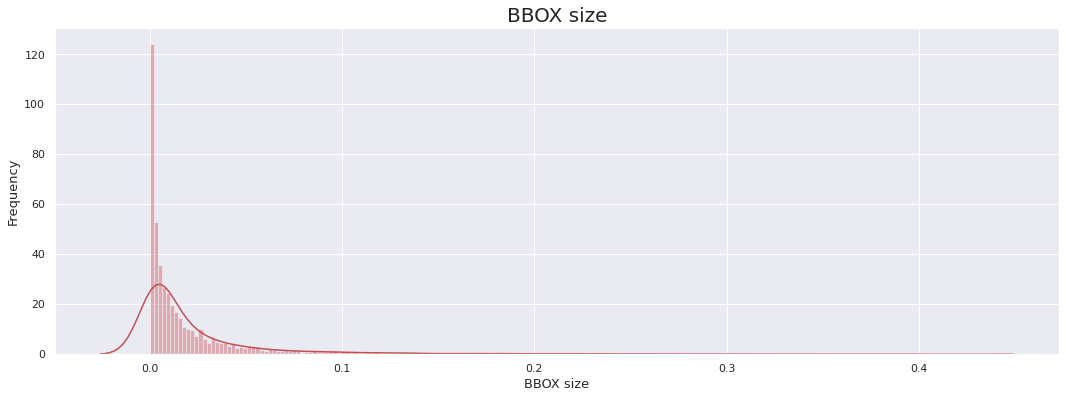

In [21]:
plot_dist(df=word_df, field='bbox_size', bins=200, color='r', xlabel='BBOX size', \
          ylabel='Frequency', title='BBOX size')

In [22]:
word_df['bbox_size']

0       0.048589
1       0.025967
2       0.031213
3       0.057850
4       0.062125
          ...   
3603    0.002829
3604    0.001953
3605    0.096054
3606    0.248245
3607    0.242564
Name: bbox_size, Length: 3608, dtype: float64

### 2.1 25%, 50%, 75% 기준으로 구간 나누어보기
- 단순 확인용

In [25]:
print(word_df.describe()['bbox_size']['min'])
print(word_df.describe()['bbox_size']['max'])

1.4239537499822007e-05
0.4236038208150201


In [98]:
word_df_1 = word_df.loc[word_df['bbox_size'] <= word_df.describe()['bbox_size']['25%']]
word_df_1.head(10)
print(min(word_df_1['bbox_size']), max(word_df_1['bbox_size']))
print(min(word_df_1['bbox_size']) / max(word_df_1['bbox_size']))

,image,index,orientation,language,bbox_size
7,img_4234.jpg,7,Horizontal,en,0.000588
8,img_4234.jpg,8,Horizontal,en,0.000546
9,img_4234.jpg,9,Horizontal,en,0.000406
10,img_4234.jpg,10,Horizontal,en,0.001539
11,img_4234.jpg,11,Horizontal,en,0.000757
17,img_4345.jpg,17,Horizontal,en,0.001246
18,img_4345.jpg,18,Horizontal,en,0.001135
21,img_4273.jpg,21,Horizontal,en,0.000654
22,img_4273.jpg,22,Horizontal,ko,0.000498
23,img_4273.jpg,23,Horizontal,en,0.000256


1.4239537499822007e-05 0.0018964334705075445
0.0075085879474649135


In [99]:
word_df_2 = word_df.loc[
    (word_df['bbox_size'] > word_df.describe()['bbox_size']['25%']) &
    (word_df['bbox_size'] <= word_df.describe()['bbox_size']['50%'])]
word_df_2.head(10)
print(min(word_df_2['bbox_size']), max(word_df_2['bbox_size']))
print(min(word_df_2['bbox_size']) / max(word_df_2['bbox_size']))

,image,index,orientation,language,bbox_size
12,img_4345.jpg,12,Horizontal,ko,0.007863
15,img_4345.jpg,15,Horizontal,ko,0.004405
16,img_4345.jpg,16,Horizontal,en,0.002865
26,img_4609.jpg,26,Horizontal,en,0.007183
29,img_4072.jpg,29,Horizontal,ko,0.002259
34,img_4072.jpg,34,Horizontal,ko,0.005021
36,img_4366.jpg,36,Horizontal,ko,0.002812
38,img_4366.jpg,38,Horizontal,en,0.002031
39,img_4366.jpg,39,Horizontal,en,0.002958
48,img_4249.jpg,48,Horizontal,en,0.007382


0.0018968621399176957 0.00821398820966295
0.23093071130613796


In [100]:
word_df_3 = word_df.loc[
    (word_df['bbox_size'] > word_df.describe()['bbox_size']['50%']) &
    (word_df['bbox_size'] <= word_df.describe()['bbox_size']['75%'])]
word_df_3.head(10)
print(min(word_df_3['bbox_size']), max(word_df_3['bbox_size']))
print(min(word_df_3['bbox_size']) / max(word_df_3['bbox_size']))

,image,index,orientation,language,bbox_size
13,img_4345.jpg,13,Horizontal,ko,0.015287
14,img_4345.jpg,14,Horizontal,ko,0.008981
25,img_4609.jpg,25,Horizontal,ko,0.009019
27,img_4609.jpg,27,Horizontal,ko,0.013179
28,img_4609.jpg,28,Horizontal,ko,0.023738
33,img_4072.jpg,33,Horizontal,ko,0.008450
37,img_4366.jpg,37,Horizontal,ko,0.010132
42,img_4366.jpg,42,Horizontal,en,0.014524
51,img_4508.jpg,51,Horizontal,ko,0.015728
52,img_4508.jpg,52,Horizontal,en,0.018751


0.008223332906147207 0.025576211784641232
0.3215227092811845


In [101]:
word_df_4 = word_df.loc[word_df['bbox_size'] > word_df.describe()['bbox_size']['75%']]
word_df_4.head(10)
print(min(word_df_4['bbox_size']), max(word_df_4['bbox_size']))
print(min(word_df_4['bbox_size']) / max(word_df_4['bbox_size']))

,image,index,orientation,language,bbox_size
0,img_4380.jpg,0,Horizontal,ko,0.048589
1,img_4380.jpg,1,Horizontal,ko,0.025967
2,img_4380.jpg,2,Horizontal,ko,0.031213
3,img_4583.jpg,3,Horizontal,en,0.057850
4,img_4583.jpg,4,Horizontal,ko,0.062125
5,img_4234.jpg,5,Horizontal,ko,0.064433
6,img_4234.jpg,6,Horizontal,ko,0.055398
19,img_4016.jpg,19,Horizontal,ko,0.075199
20,img_4273.jpg,20,Horizontal,ko,0.051151
24,img_4609.jpg,24,Horizontal,en,0.052009


0.025600685989719055 0.4236038208150201
0.06043544635754925


### 2.2 `pd.qcut` 함수 사용해보기
- https://kongdols-room.tistory.com/175
- https://rfriend.tistory.com/404
- https://blog.naver.com/youji4ever/221671830297

In [102]:
word_df_cut = pd.qcut(word_df.bbox_size, [0, 0.3, 0.6, 0.8, 0.95, 1])
word_df_cut

0             (0.0329, 0.106]
1            (0.0126, 0.0329]
2            (0.0126, 0.0329]
3             (0.0329, 0.106]
4             (0.0329, 0.106]
                ...          
3603        (0.00266, 0.0126]
3604    (-0.0009858, 0.00266]
3605          (0.0329, 0.106]
3606           (0.106, 0.424]
3607           (0.106, 0.424]
Name: bbox_size, Length: 3608, dtype: category
Categories (5, interval[float64, right]): [(-0.0009858, 0.00266] < (0.00266, 0.0126] < (0.0126, 0.0329] < (0.0329, 0.106] < (0.106, 0.424]]

In [103]:
grouped = word_df.bbox_size.groupby(word_df_cut)

grouped.agg(['count', 'mean', 'std', 'min', 'max'])

,count,mean,std,min,max
bbox_size,,,,,
"(-0.0009858, 0.00266]",1083,0.001039,0.000741,0.000014,0.002658
"(0.00266, 0.0126]",1082,0.006773,0.002838,0.002660,0.012575
"(0.0126, 0.0329]",721,0.020749,0.005732,0.012584,0.032860
"(0.0329, 0.106]",541,0.057208,0.019885,0.032976,0.106336
"(0.106, 0.424]",181,0.179855,0.066888,0.106447,0.423604


In [116]:
# word_df에 bbox_size_group column 추가
word_df['bbox_size_cut'] = pd.qcut(word_df.bbox_size, [0, 0.3, 0.6, 0.8, 0.95, 1], labels=['A', 'B', 'C', 'D', 'E'])
word_df

,image,index,orientation,language,bbox_size,bbox_size_group,bbox_size_cut
0,img_4380.jpg,0,Horizontal,ko,0.048589,D,D
1,img_4380.jpg,1,Horizontal,ko,0.025967,C,C
2,img_4380.jpg,2,Horizontal,ko,0.031213,C,C
3,img_4583.jpg,3,Horizontal,en,0.057850,D,D
4,img_4583.jpg,4,Horizontal,ko,0.062125,D,D
...,...,...,...,...,...,...,...
3603,img_1122.jpg,3603,Horizontal,ko,0.002829,B,B
3604,img_1122.jpg,3604,Horizontal,ko,0.001953,A,A
3605,img_1131.jpg,3605,Horizontal,ko,0.096054,D,D
3606,img_1100.jpg,3606,Horizontal,ko,0.248245,E,E


## 3. train / val set 나누어보기
- `pd.qcut` 결과를 이용해서 `StratifiedGroupKFold`를 수행한다.
- `groups` = `image`
    - 같은 이미지가 동시에 train / val set에 들어가지 않도록 하기 위해서 image 이름을 group으로 설정한다.
- `y` = `bbox_size_cut`
    - bbox size별 구간(A ~ E)을 class처럼 생각한다.
- https://comlini8-8.tistory.com/97?category=896454

### 3.1 살펴보기

In [105]:
import json
import numpy as np
from sklearn.model_selection import StratifiedGroupKFold

In [106]:
annotation = "/opt/ml/input/data/ICDAR17_Korean/ufo/train.json"
target_dir = "/opt/ml/input/data/ICDAR17_Korean/ufo/"

In [107]:
with open(annotation) as f:
    data = json.load(f)

In [115]:
#data["images"]

In [111]:
word_df["image"]

0       img_4380.jpg
1       img_4380.jpg
2       img_4380.jpg
3       img_4583.jpg
4       img_4583.jpg
            ...     
3603    img_1122.jpg
3604    img_1122.jpg
3605    img_1131.jpg
3606    img_1100.jpg
3607    img_1100.jpg
Name: image, Length: 3608, dtype: object

In [125]:
# groups(image_id), y(bbox_size_cut)
var = []
for i in range(len(word_df)):
    var.append((word_df.iloc[i]["image"], word_df.iloc[i]["bbox_size_cut"]))

In [124]:
len(word_df)

3608

In [129]:
# 확인용
var[3607]

('img_1100.jpg', 'E')

In [130]:
X = np.ones((len(word_df)))
y = np.array([v[1] for v in var])
groups = np.array([v[0] for v in var])

cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=1333)

In [162]:
for train_idx, val_idx in cv.split(X, y, groups):
    # print("TRAIN:", groups[train_idx]) 
    # print("      ", y[train_idx]) 
    # print(" TEST:", groups[val_idx]) 
    # print("      ", y[val_idx])
    
    # train set과 valid set의 image_id가 겹치는지 확인
    assert len(set(groups[train_idx]) & set(groups[val_idx])) == 0

print("Success :)")

Success :)


### 3.2 잘 나누어졌는지 확인
- train / val set 간 중복되는 image가 있는지 확인한다.

In [139]:
import pandas as pd
from collections import Counter, defaultdict

In [159]:
# check distribution
def get_distribution(y):
    y_distr = Counter(y)
    y_vals_sum = sum(y_distr.values())
    
    return [f'{y_distr[i]/y_vals_sum:.2%}' for i in ['A', 'B', 'C', 'D', 'E']]

distrs = [get_distribution(y)]
index = ['training set']

for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X, y, groups)):
    train_y, val_y = y[train_idx], y[val_idx]
    train_gr, val_gr = groups[train_idx], groups[val_idx]
    
    assert len(set(train_gr) & set(val_gr)) == 0
    
    distrs.append(get_distribution(train_y))
    distrs.append(get_distribution(val_y))
    
    index.append(f'train - fold{fold_idx}')
    index.append(f'val - fold{fold_idx}')
    
categories = ['A', 'B', 'C', 'D', 'E']

pd.DataFrame(distrs, index=index, columns = [categories[i] for i in range(len(categories))])

,A,B,C,D,E
training set,30.02%,29.99%,19.98%,14.99%,5.02%
train - fold0,30.72%,30.68%,19.44%,14.37%,4.79%
val - fold0,26.92%,26.92%,22.41%,17.74%,6.02%
train - fold1,31.76%,27.96%,19.79%,15.25%,5.24%
val - fold1,23.28%,37.82%,20.73%,14.00%,4.17%
train - fold2,26.14%,32.12%,20.70%,15.70%,5.33%
val - fold2,42.59%,23.06%,17.65%,12.71%,4.00%
train - fold3,30.51%,29.36%,20.05%,15.24%,4.84%
val - fold3,27.85%,32.74%,19.70%,13.93%,5.78%
train - fold4,30.75%,29.90%,19.98%,14.46%,4.91%


### 3.3 CV set 나눈 것으로 json 파일 만들기
- 위에서 확인만 했던 것을 json 파일로 만들어본다.
- https://github.com/boostcampaitech2/data-annotation-cv-level3-cv-14/blob/ab5ad99205ce1fed4ec4d5b8e236a95168082bac/dataset_spliter.py

In [179]:
import json
import numpy as np
from sklearn.model_selection import StratifiedGroupKFold
import os

train_src_path = "/opt/ml/input/data/ICDAR17_Korean/ufo/train.json"
target_dir = "/opt/ml/input/data/ICDAR17_Korean/ufo/"

with open(train_src_path,'r') as f:
    train_src = json.load(f)

In [180]:
# train_src["images"]

In [181]:
# groups(image_id), y(bbox_size_cut)
var = []
for i in range(len(word_df)):
    var.append((word_df.iloc[i]["image"], word_df.iloc[i]["bbox_size_cut"]))

In [185]:
print(var[3607], len(var))

('img_1100.jpg', 'E') 3608


In [186]:
X = np.ones((len(word_df)))
y = np.array([v[1] for v in var])
groups = np.array([v[0] for v in var])

# seed?
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=1333)

In [187]:
# 확인용 (첫 번째 fold)
train_idx, val_idx = next(cv.split(X, y, groups))
print("TRAIN:", groups[train_idx]) # image_name
print("      ", y[train_idx])  # bbox_size_cut
# print(" TEST:", groups[val_idx]) 
# print("      ", y[val_idx])

TRAIN: ['img_4380.jpg' 'img_4380.jpg' 'img_4380.jpg' ... 'img_1131.jpg'
 'img_1100.jpg' 'img_1100.jpg']
       ['D' 'C' 'C' ... 'D' 'E' 'E']


In [188]:
for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X, y, groups)):
    ## groups(image_name), y(bbox_size_cut)
    # print("TRAIN:", groups[train_idx]) # image_name
    # print("      ", y[train_idx])  # bbox_size_cut
    # print(" TEST:", groups[val_idx]) 
    # print("      ", y[val_idx])
    
    train_gr, val_gr = groups[train_idx], groups[val_idx]
    
    # train set과 val set에 중복되는 image가 있는지 확인
    assert len(set(train_gr) & set(val_gr)) == 0
    
    train = {"images": {}}
    val = {"images": {}}
    
    # train set
    for img in train_gr:
        train["images"][img] = train_src["images"][img]
    print(f"len(train_{fold_idx}) = {len(train['images'])}")
    
    # val set
    for img in val_gr:
        val["images"][img] = train_src["images"][img]
    print(f"len(val_{fold_idx}) = {len(val['images'])}")
    
    with open(os.path.join(target_dir, f'train_{fold_idx}.json'), 'w') as f:
        json.dump(train, f, indent="\t")
    with open(os.path.join(target_dir, f'val_{fold_idx}.json'), 'w') as f:
        json.dump(val, f, indent="\t")
    
    print("Completed")

len(train_0) = 429
len(val_0) = 107
Completed
len(train_1) = 427
len(val_1) = 109
Completed
len(train_2) = 430
len(val_2) = 106
Completed
len(train_3) = 430
len(val_3) = 106
Completed
len(train_4) = 428
len(val_4) = 108
Completed
